# Testing bias metrics and mitigation algorithms on the Adult Income dataset

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OrdinalEncoder
from aif360.algorithms.preprocessing import Reweighing, DisparateImpactRemover
from Sampler import Sampler
from utility import *
sns.set_theme(style='darkgrid')

In [2]:
def load_dataset():
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 
                'occupation','relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
    adult_df = pd.read_csv('adult/adult.data', names=column_names)
    adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (adult_df['race'] != ' White')].index,inplace=True)
    adult_df.loc[adult_df['native-country'] == ' ?', 'native-country'] = 'Not known'
    return adult_df

## Dataset description

The Adult Income dataset contains informations about the income of people extracted from the 1994 Census database. Prediction task is to determine whether a person makes over 50K a year. It has been shown that the dataset is bias in favor of white men and against women and people of other races.

## Dataset fairness metrics definition

The group fairness metrics related to the dataset are defined as follows:

- **Disparate impact**

$$
\frac{Pr(Y=1|S=unprivileged)}{Pr(Y=1|S=privileged)}
$$

> If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data

- **Statistical parity**

$$
Pr(Y=1|S=unprivileged)-Pr(Y=1|S=privileged)
$$

## Classifier fairness metrics definition

The group fairness metrics related to the classifier are defined below:

- **Balanced Accuracy**

$$
\frac{TP + TN}{2}
$$

- **Statistical parity**

$$
Pr(\hat{Y}=1|S=unprivileged)-Pr(\hat{Y}=1|S=privileged)
$$

- **Disparate Impact**

$$
\frac{Pr(\hat{Y}=1|S=unprivileged)}{Pr(\hat{Y}=1|S=privileged)}
$$

>If the value is less than 0.8 or more than 1.2 we say that there is a _disparate impact_ on data
- **Average odds difference**

$$
\frac{[(FPR_{S=unpriv} - FPR_{S=priv})+(TPR_{S=unpriv} - TPR_{S=priv})]}{2}
$$
>A value of 0 means _equality of odds_

- **Equal opportunity difference**

$$
TPR_{S=unpriv} - TPR_{S=priv}
$$

- **Theil Index**

$$
\frac{1}{n}\sum_{i=1}^n\frac{b_{i}}{\mu}\ln(\frac{b_{i}}{\mu}) \\
\text{with: } b_i=\hat{y_i}-y_i+1 \text{ and $\mu$ is the mean of $b_i$ }
$$
>Individual index measuring the distance of each individual predicted y from his real value. A value of 0 means equality. 

## Bias mitigation algorithms

In the following we will test two preprocessing bias mitigation algorithms and we will compare the impact they have on the model accuracy. The algorithms that we will test are the following:

1. **Reweighing**
    
> Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification

2. **Disparate Impact Remover**

> This algorithm changes the values of the unsensitive variables at different levels of repair. An higher level of repair removes the disparate impact but loweres the accuracy, while a low level of repair does not change the data. The values of the unsensitive attributes are changed s.t. the correlation between the variables and the sensitive attribute _S_ is removed while keeping the ranking of the items for the classifier. In this way it is no more possible to predict the sensitive variable _S_ from the unsensitive attributes.
>
> Following the pre processing procedure suggested by M. Feldman et al. in _"Certifying and removing disparate impact." ACM SIGKDD International Conference on Knowledge Discovery and Data Mining, 2015_, we first scale the values s.t. the minimum is 0 and the maximum is 1 and then remove the sensitive variable from the dataset before training the classifier.
>
>**NB:** Categorical data must be transformed in ordered values

3. **Sampling**

> Sampling is a modified version of the Reweighing algorithm. First of all, it considered the groups made by each combinantion of the values of sensitive variables and labels. Then, for each group it computes his disparity ($\frac{size\_exp}{size\_obs}$) and samples each group untill this value becomes 1. The final dataset will be a dataset in which each group is balanced.

# Importing and exploring the dataset

In [3]:
adult_df = load_dataset()
adult_df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult_df.shape

(30940, 15)

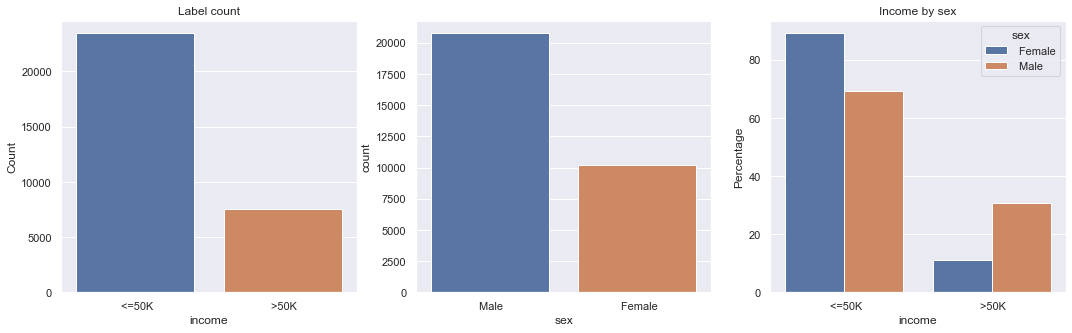

In [5]:
fig,ax = plt.subplots(1,3,figsize=(18,5))
sns.barplot(x='income', y='percentage', 
            data=adult_df[['sex','income']].groupby('sex')['income'].value_counts(normalize=True).rename('percentage').mul(100).reset_index(),
            hue='sex',
            ax=ax[2])
sns.countplot(x='income', data=adult_df, ax=ax[0])
sns.countplot(x='sex', data=adult_df, ax=ax[1])
ax[2].set(ylabel='Percentage', title="Income by sex")
ax[0].set(ylabel='Count', title="Label count")
plt.show()

So we are in an **Unbalanced Bias Dataset** case.

## Dataset transformation

In [6]:
lab_enc = LabelEncoder()
ord_enc = OrdinalEncoder()

In [7]:
adult_df['age_class'] = pd.cut(adult_df['age'],
                               bins=[0,9,19,29,39,49,59,69,99],
                               labels=['age<10','age between 10 and 20','age between 20 and 30',
                                       'age between 30 and 40','age between 40 and 50',
                                       'age between 50 and 60','age between 60 and 70','age>70']
                              )
adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                               bins=[0,9,19,29,39,49,99],
                               labels=['hour<10','hours between 10 and 20','hours between 20 and 30',
                                       'hours between 30 and 40','hour between 40 and 50',
                                       'hour>70']
                              )
adult_df.drop(labels=['hours-per-week','workclass','fnlwgt','capital-gain','capital-loss','age','education-num'],
              axis=1,inplace=True)
adult_df = adult_df.join(pd.get_dummies(adult_df['education'])).drop('education',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['marital-status'])).drop('marital-status',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['occupation'])).drop('occupation',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['relationship'])).drop('relationship',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['native-country'])).drop('native-country',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['age_class'])).drop('age_class',axis=1)
adult_df = adult_df.join(pd.get_dummies(adult_df['hour-per-week-class'])).drop('hour-per-week-class',axis=1)
adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
adult_df[['sex','race']] = ord_enc.fit_transform(adult_df[['sex','race']])

# Bias dataset and classification metrics

Create a StructuredDataset object to which apply fairness metrics and methods

In [8]:
unprivileged_group = [{'sex': 0}]
privileged_group = [{'sex': 1}]

In [9]:
data = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=adult_df, label_names=['income'], protected_attribute_names=['sex'])

## Bias Dataset

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8111
Statistical parity difference: -0.3549
Disparate impact: 0.2836
Average odds difference: -0.2227
Equal opportunity difference: -0.1946
Theil index: 0.0829


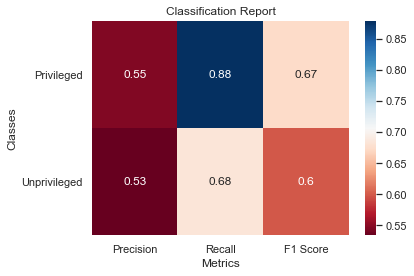

In [10]:
class_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    data, privileged_group, unprivileged_group)

## Reweighing

In [11]:
rw_data = data.copy()
rw = Reweighing(unprivileged_group, privileged_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.8002
Statistical parity difference: -0.0627
Disparate impact: 0.8396
Average odds difference: -0.0305
Equal opportunity difference: 0.0320
Theil index: 0.0899


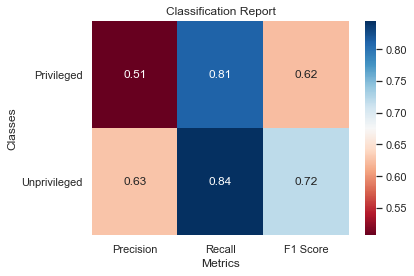

In [12]:
rw_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_data, privileged_group, unprivileged_group, debiaser=rw)

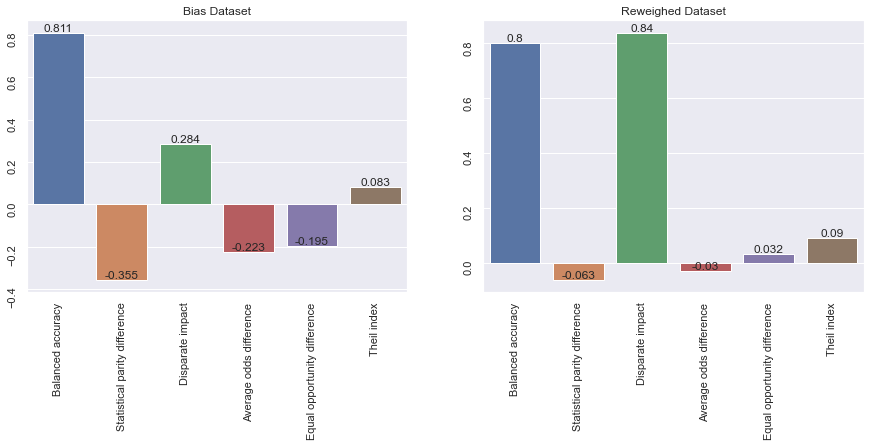

In [13]:
plot_metrics_comparison(class_metrics, rw_class, "Bias Dataset", "Reweighed Dataset")
plt.show()

## Disparate Impact Remover

First we will apply the DIR to the One Hot Encoded dataset and see if it has some effects on the bias mitigation

In [14]:
dir_data = data.copy()
scaler = MinMaxScaler(copy=False)
dir_data.features = scaler.fit_transform(dir_data.features)

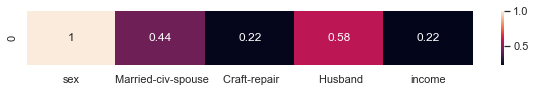

In [15]:
df = dir_data.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

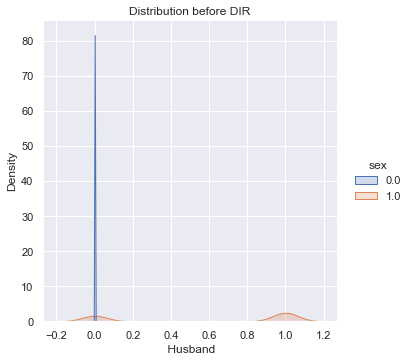

In [16]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

Apply DIR and check correlation changes:

In [17]:
di = DisparateImpactRemover(sensitive_attribute='sex')
dir_data_trans = di.fit_transform(dir_data)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


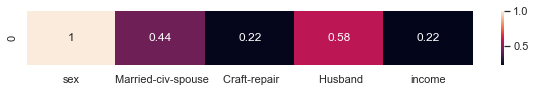

In [18]:
df = dir_data_trans.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr[corr[0] > .2].T, ax=ax, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


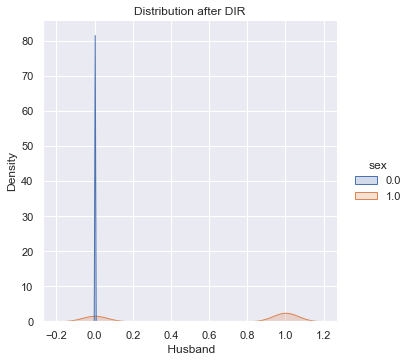

In [19]:
sns.displot(data=df, x=' Husband', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
plt.show()

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.8101
Statistical parity difference: -0.3163
Disparate impact: 0.3478
Average odds difference: -0.1691
Equal opportunity difference: -0.1213
Theil index: 0.0831


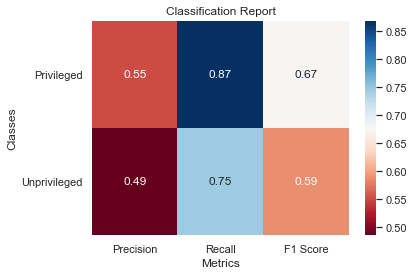

In [20]:
dir_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


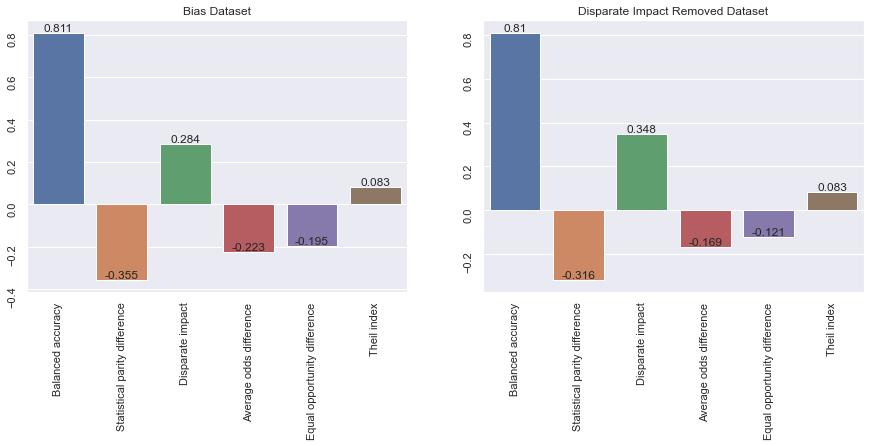

In [21]:
plot_metrics_comparison(class_metrics, dir_class, 'Bias Dataset', 'Disparate Impact Removed Dataset')
plt.show()

## Modified Reweighing (Sampling)

In [27]:
sampled_data = data.copy()
sampler = Sampler(round_level=2)

### Classification Metrics

### Dataset Metrics:

Disparate Impact: 0.9853
Statistical Parity: -0.0036




### Classification Metrics:

Balanced accuracy: 0.8012
Statistical parity difference: -0.0731
Disparate impact: 0.8151
Average odds difference: -0.0403
Equal opportunity difference: 0.0196
Theil index: 0.0887


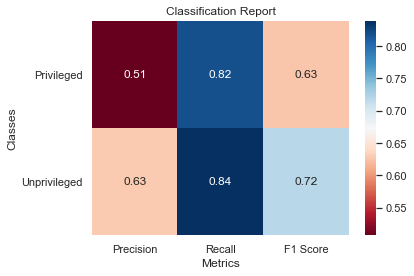

In [28]:
sampled_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    sampled_data, privileged_group, unprivileged_group, debiaser=sampler)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


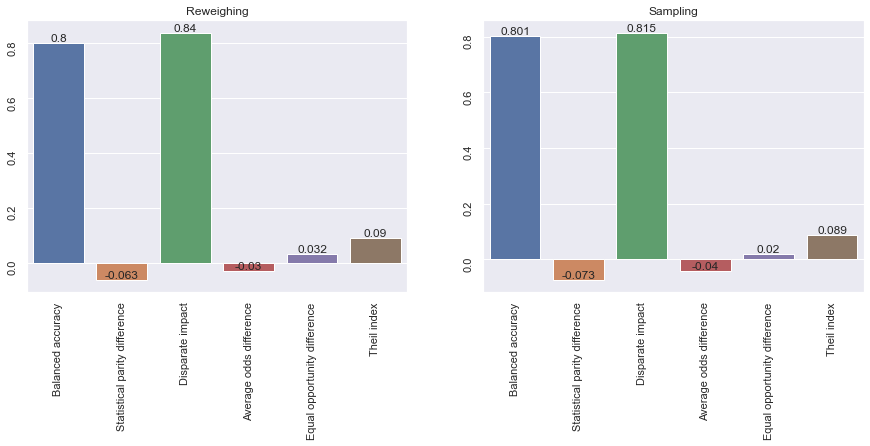

In [29]:
plot_metrics_comparison(rw_class, sampled_metrics, 'Reweighing', 'Sampling')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.2227,0.8111,0.2836,-0.1946,-0.3549,0.0829
DIR Dataset,-0.1691,0.8101,0.3478,-0.1213,-0.3163,0.0831
Reweighed Dataset,-0.0305,0.8002,0.8396,0.0320,-0.0627,0.0899
Sampled Dataset,-0.0403,0.8012,0.8151,0.0196,-0.0731,0.0887


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


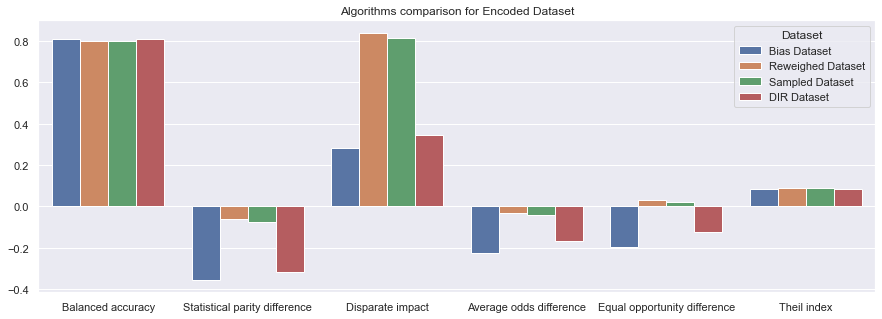

In [30]:
plot_syntesis(merge_datasets({
    'Bias Dataset': class_metrics,
    'Reweighed Dataset': rw_class,
    'Sampled Dataset': sampled_metrics,
    'DIR Dataset': dir_class,
}), "Algorithms comparison for Encoded Dataset")
plt.show()

# Test with numerical data

In [31]:
df = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country','race']
df.drop(df[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df['sex'] = le.fit_transform(df['sex'])
df['income'] = le.fit_transform(df['income'])
df

,age,education-num,sex,capital-gain,capital-loss,hours-per-week,income
0,39,13,1,2174,0,40,0
1,50,13,1,0,0,13,0
2,38,9,1,0,0,40,0
3,53,7,1,0,0,40,0
4,28,13,0,0,0,40,0
...,...,...,...,...,...,...,...
32556,27,12,0,0,0,38,0
32557,40,9,1,0,0,40,1
32558,58,9,0,0,0,40,0
32559,22,9,1,0,0,20,0


## Bias Dataset

In [32]:
df_bin = BinaryLabelDataset(
    favorable_label=1, unfavorable_label=0, df=df, label_names=['income'], protected_attribute_names=['sex'])

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7612
Statistical parity difference: -0.3610
Disparate impact: 0.2350
Average odds difference: -0.3105
Equal opportunity difference: -0.3674
Theil index: 0.1092


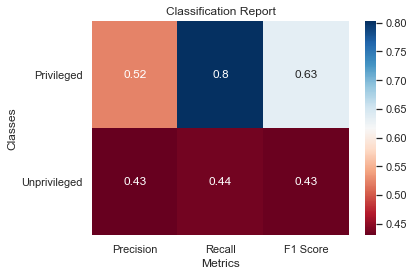

In [33]:
df_ord_class = classify(make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
                        df_bin, privileged_group, unprivileged_group)

## Reweighing

In [34]:
rw = Reweighing(unprivileged_group, privileged_group)
df_bin_rw = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7342
Statistical parity difference: 0.0012
Disparate impact: 1.0037
Average odds difference: -0.0080
Equal opportunity difference: -0.0260
Theil index: 0.1210


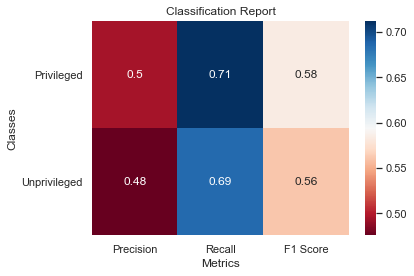

In [36]:
rw_ord_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    df_bin_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


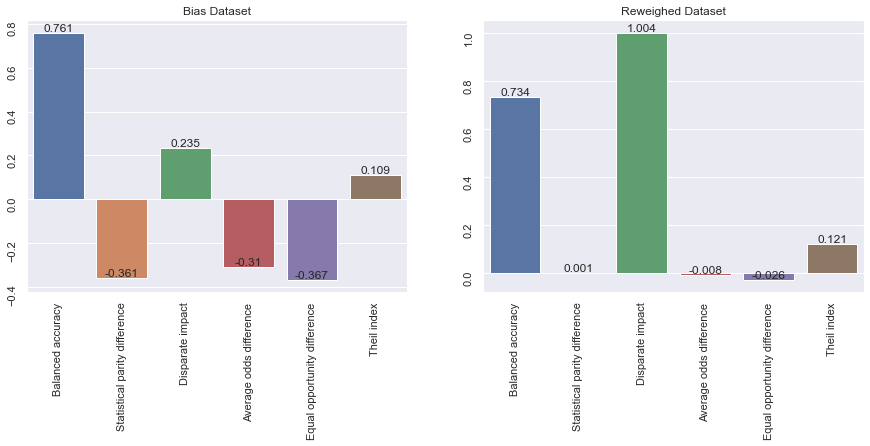

In [37]:
plot_metrics_comparison(df_ord_class, rw_ord_class, 'Bias Dataset', 'Reweighed Dataset')
plt.show()

## DIR

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


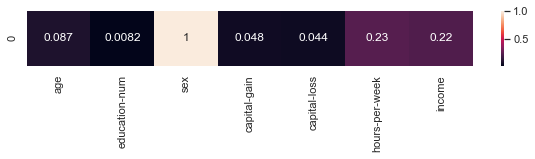

In [38]:
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


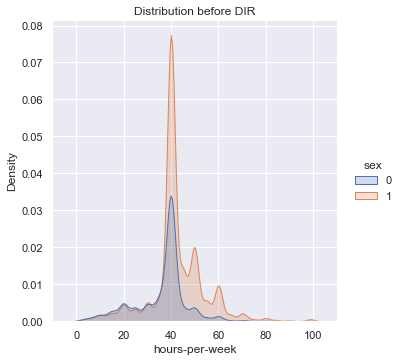

In [39]:
sns.displot(data=df, x='hours-per-week', hue='sex', kind='kde', multiple='layer', fill=True)
plt.title('Distribution before DIR')
plt.show()

In [40]:
df_dir = df_bin.copy()
scaler = MinMaxScaler(copy=False)
df_dir.features = scaler.fit_transform(df_bin.features)

In [41]:
di = DisparateImpactRemover(sensitive_attribute='sex')
df_dir = di.fit_transform(df_bin)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


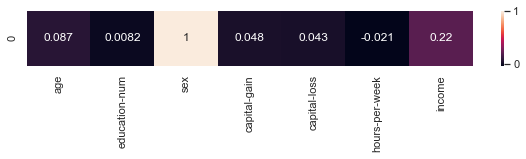

In [42]:
df = df_dir.convert_to_dataframe()[0]
corr = df.corrwith(df['sex'])
corr = pd.DataFrame(corr)
fig, ax = plt.subplots(1,1,figsize=(10,1))
sns.heatmap(corr.T, annot=True)
plt.show()

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


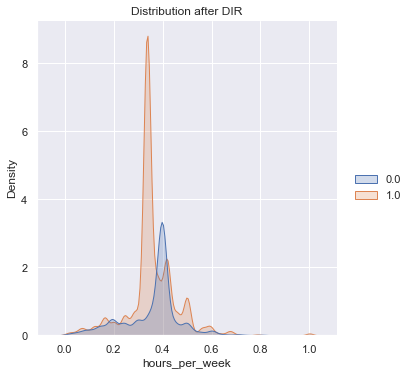

In [43]:
ax = sns.displot(x=df_dir.features[:,5], hue=df_dir.features[:,2], kind='kde', multiple='layer', fill=True)
plt.title('Distribution after DIR')
ax.set(xlabel='hours_per_week')
plt.show()

### Dataset Metrics:

Disparate Impact: 0.3561
Statistical Parity: -0.1982




### Classification Metrics:

Balanced accuracy: 0.7320
Statistical parity difference: -0.0629
Disparate impact: 0.8329
Average odds difference: 0.0160
Equal opportunity difference: -0.0045
Theil index: 0.1225


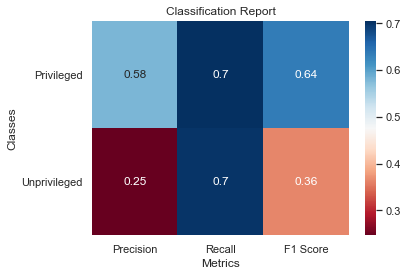

In [44]:
dir_ord_class = classify(make_pipeline(
    StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
                         df_dir, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


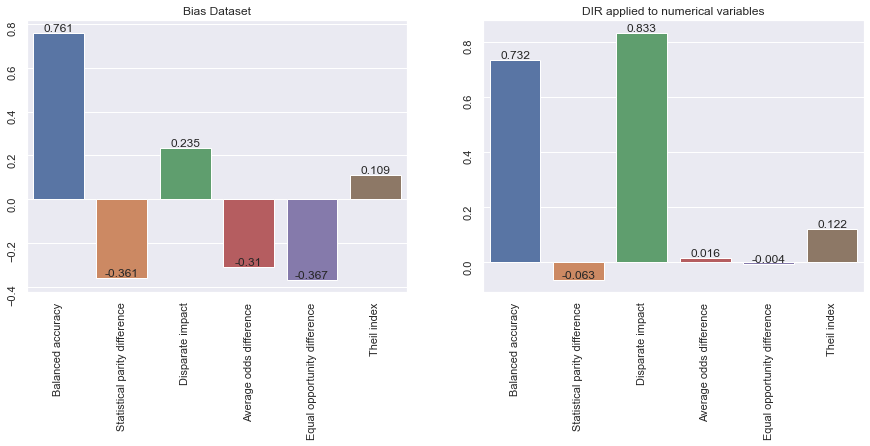

In [45]:
plot_metrics_comparison(df_ord_class, dir_ord_class, 'Bias Dataset', 'DIR applied to numerical variables')
plt.show()

## Modified Reweighing (Sampling)

In [47]:
sampler = Sampler(round_level=2)
sampled_num = df_bin.copy()

### Dataset Metrics:

Disparate Impact: 0.9853
Statistical Parity: -0.0036




### Classification Metrics:

Balanced accuracy: 0.7321
Statistical parity difference: -0.0097
Disparate impact: 0.9728
Average odds difference: -0.0174
Equal opportunity difference: -0.0352
Theil index: 0.1238


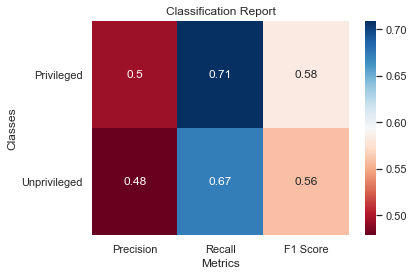

In [48]:
sampled_num_metrics = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled_num, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


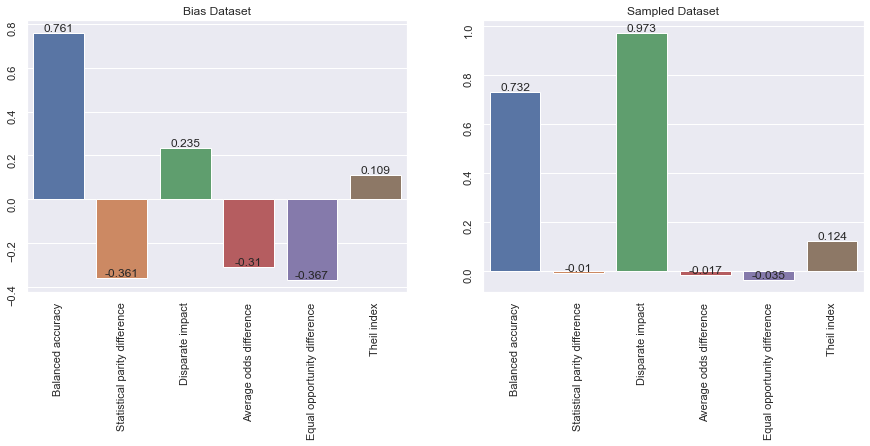

In [49]:
plot_metrics_comparison(df_ord_class, sampled_num_metrics, 'Bias Dataset', 'Sampled Dataset')
plt.show()

## Reweighing vs DIR vs Sampling

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3105,0.7612,0.2350,-0.3674,-0.3610,0.1092
DIR Dataset,0.0160,0.7320,0.8329,-0.0045,-0.0629,0.1225
Reweighed Dataset,-0.0080,0.7342,1.0037,-0.0260,0.0012,0.1210
Sampled Dataset,-0.0174,0.7321,0.9728,-0.0352,-0.0097,0.1238


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


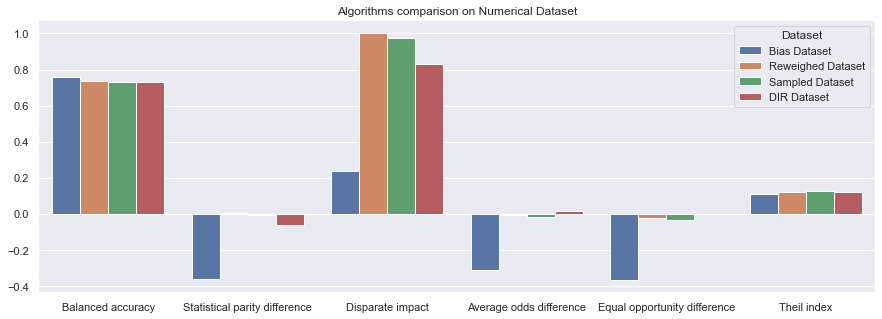

In [50]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df_ord_class,
    'Reweighed Dataset': rw_ord_class,
    'Sampled Dataset': sampled_num_metrics,
    'DIR Dataset': dir_ord_class,
}), 'Algorithms comparison on Numerical Dataset')
plt.show()

# Reweighing + DIR

## Dataset with One Hot Encoded attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


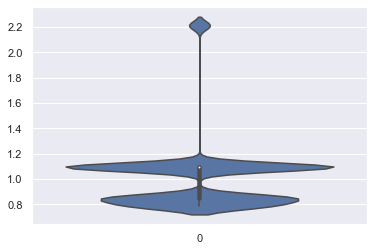

In [51]:
rw_dir_enc = dir_data.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_enc = rw.fit_transform(rw_dir_enc)
sns.violinplot(data=rw_dir_enc.instance_weights)
plt.show()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.8016
Statistical parity difference: -0.0867
Disparate impact: 0.7819
Average odds difference: -0.0547
Equal opportunity difference: 0.0072
Theil index: 0.0880


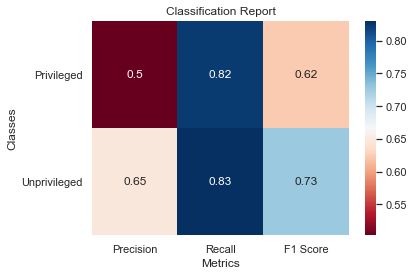

In [52]:
rw_dir_enc_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    rw_dir_enc, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


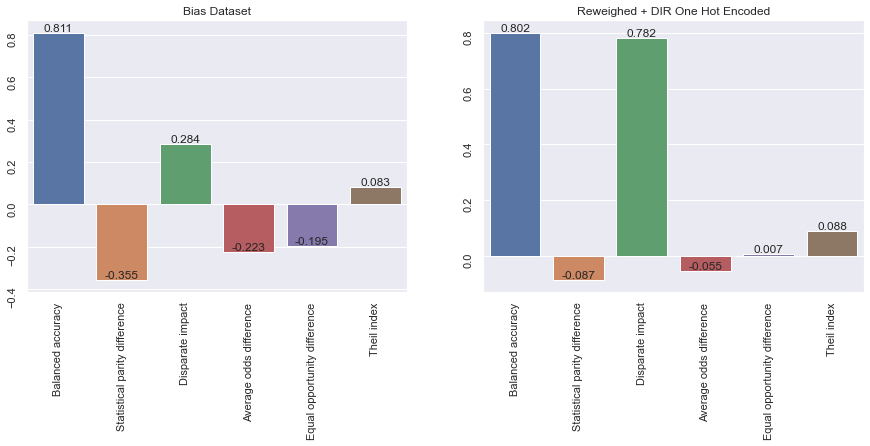

In [53]:
plot_metrics_comparison(class_metrics, rw_dir_enc_score, 'Bias Dataset', 'Reweighed + DIR One Hot Encoded')
plt.show()

## Dataset with numerical attributes

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


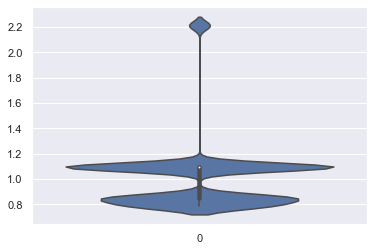

In [54]:
rw_dir_data = df_dir.copy()
rw = Reweighing(unprivileged_group, privileged_group)
rw_dir_data = rw.fit_transform(rw_dir_data)
sns.violinplot(data= rw_dir_data.instance_weights)
plt.show()

In [55]:
metrics = compute_dataset_fairness_metrics(rw_dir_data, unprivileged_group, privileged_group)

Disparate Impact = 1.0000
Statistical Parity = 0.0000


### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7331
Statistical parity difference: 0.0316
Disparate impact: 1.0955
Average odds difference: 0.0231
Equal opportunity difference: 0.0057
Theil index: 0.1230


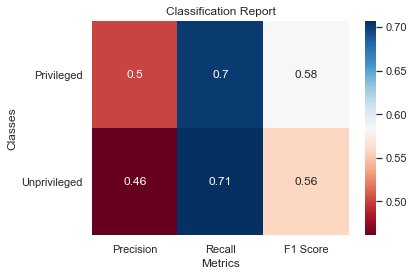

In [56]:
rw_dir_score = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')), 
    rw_dir_data, privileged_group, unprivileged_group, sensitive_attributes=['sex'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


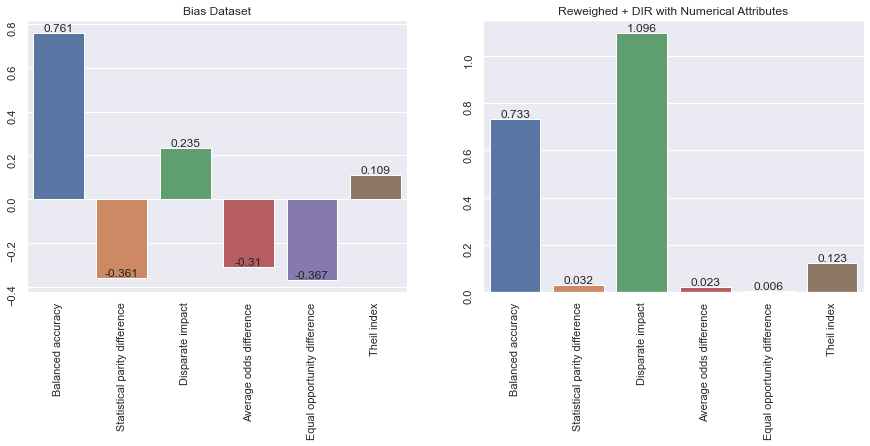

In [57]:
plot_metrics_comparison(df_ord_class, rw_dir_score, 'Bias Dataset', 'Reweighed + DIR with Numerical Attributes')
plt.show()

# Algorithms Comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset Numerical,-0.3105,0.7612,0.2350,-0.3674,-0.3610,0.1092
Bias Dataset One Hot,-0.2227,0.8111,0.2836,-0.1946,-0.3549,0.0829
Disparate Impact Remover Numerical,0.0160,0.7320,0.8329,-0.0045,-0.0629,0.1225
Disparate Impact Remover One Hot,-0.1691,0.8101,0.3478,-0.1213,-0.3163,0.0831
Reweighing + DIR Numerical,0.0231,0.7331,1.0955,0.0057,0.0316,0.1230
Reweighing + DIR One Hot,-0.0547,0.8016,0.7819,0.0072,-0.0867,0.0880
Reweighing Numerical,-0.0080,0.7342,1.0037,-0.0260,0.0012,0.1210
Reweighing One Hot,-0.0305,0.8002,0.8396,0.0320,-0.0627,0.0899
Sampled Numerical,-0.0174,0.7321,0.9728,-0.0352,-0.0097,0.1238


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


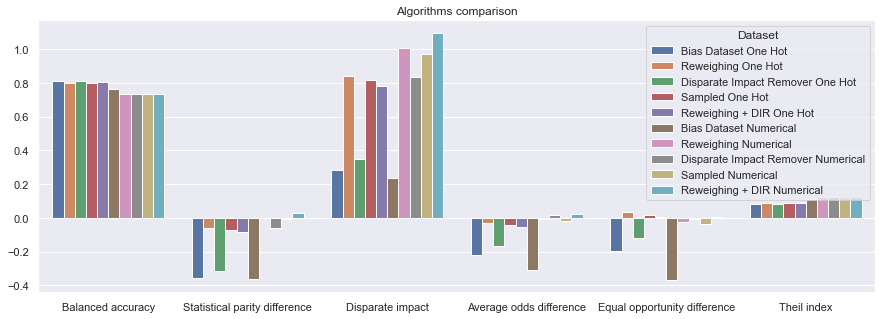

In [58]:
plot_syntesis(merge_datasets({
    'Bias Dataset One Hot': class_metrics,
    'Reweighing One Hot': rw_class,
    'Disparate Impact Remover One Hot': dir_class,
    'Sampled One Hot': sampled_metrics,
    'Reweighing + DIR One Hot': rw_dir_enc_score,
    'Bias Dataset Numerical': df_ord_class,
    'Reweighing Numerical': rw_ord_class,
    'Disparate Impact Remover Numerical': dir_ord_class,
    'Sampled Numerical': sampled_num_metrics,
    'Reweighing + DIR Numerical': rw_dir_score
}), 'Algorithms comparison')
plt.show()

# Test Adult with multiple sensitive attributes

In [59]:
df_2 = load_dataset()
drop_cols = ['workclass', 'fnlwgt', 'education', 
             'marital-status', 'occupation', 'relationship', 'native-country']
df_2.drop(df_2[drop_cols], axis=1, inplace=True)
le = LabelEncoder()
df_2['sex'] = le.fit_transform(df['sex'])
df_2['race'] = le.fit_transform(df_2['race'])

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


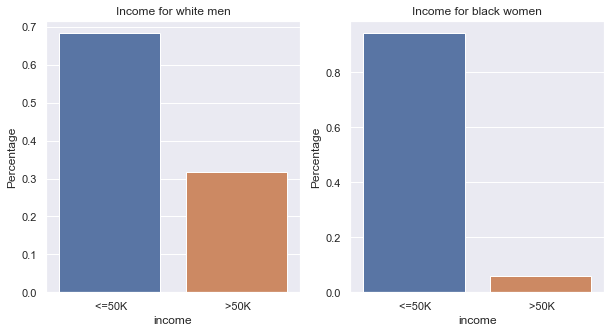

In [60]:
perc = (df_2[['sex','race','income']]
            .groupby(['sex','race'])['income']
            .value_counts(normalize=True)
            .rename('Percentage')
            .reset_index())
fig, [ax1, ax2] = plt.subplots(1,2, figsize=(10,5))
sns.barplot(data=perc[(perc['sex']==1)&(perc['race']==1)], x='income', y='Percentage', ax=ax1)
sns.barplot(data=perc[(perc['sex']==0)&(perc['race']==0)], x='income', y='Percentage', ax=ax2)
ax1.set_title('Income for white men')
ax2.set_title('Income for black women')
plt.show()

In [61]:
df_2[(df_2['sex']==0)&(df_2['race']==0)].shape

(1555, 8)

In [62]:
df_2[(df_2['sex']==1)&(df_2['race']==1)].shape

(19174, 8)

In [63]:
df_2['income'] = le.fit_transform(df_2['income'])

In [64]:
privileged_group = [{'sex': 1, 'race': 1}]
unprivileged_group = [{'sex': 0, 'race': 0}]

## Test on bias dataset

In [65]:
df_2bin = BinaryLabelDataset(df=df_2, protected_attribute_names = ['sex', 'race'], label_names=['income'])

### Dataset Metrics:

Disparate Impact: 0.1822
Statistical Parity: -0.2597




### Classification Metrics:

Balanced accuracy: 0.7623
Statistical parity difference: -0.4522
Disparate impact: 0.0890
Average odds difference: -0.3851
Equal opportunity difference: -0.4480
Theil index: 0.1083


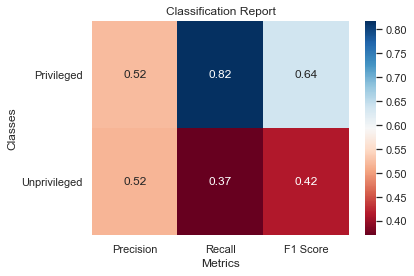

In [66]:
df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df_2bin, privileged_group, unprivileged_group)

## Reweighing

In [69]:
rw = Reweighing(unprivileged_group, privileged_group)
df2_rw = df_2bin.copy()

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: 0.0000




### Classification Metrics:

Balanced accuracy: 0.7414
Statistical parity difference: -0.1287
Disparate impact: 0.6237
Average odds difference: -0.1302
Equal opportunity difference: -0.1333
Theil index: 0.1225


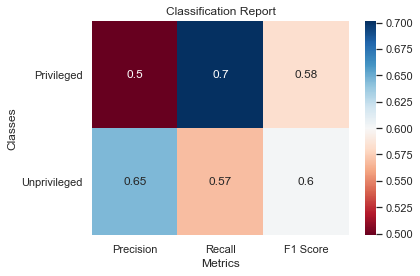

In [70]:
rw_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    df2_rw, privileged_group, unprivileged_group, debiaser=rw)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


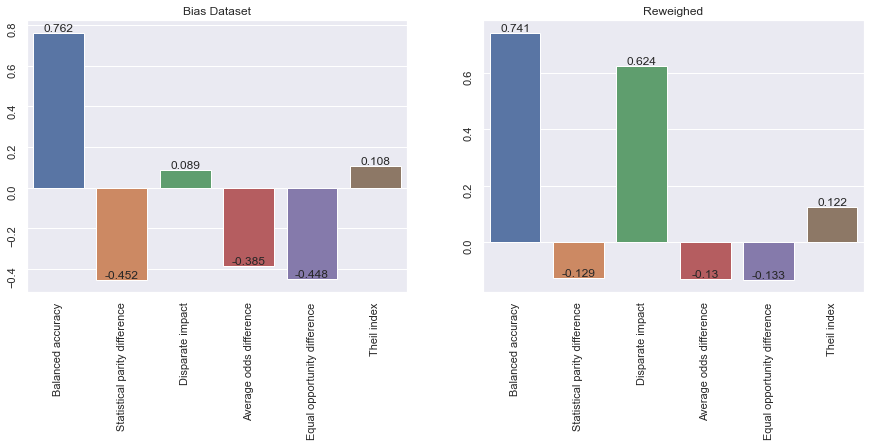

In [71]:
plot_metrics_comparison(df2_class, rw_df2_class, 'Bias Dataset', 'Reweighed')
plt.show()

## Modified Reweighing (Sampling)

In [81]:
sampled2 = df_2bin.copy()
sampler = Sampler(round_level=1)

### Dataset Metrics:

Disparate Impact: 0.8610
Statistical Parity: -0.0363




### Classification Metrics:

Balanced accuracy: 0.7316
Statistical parity difference: -0.1080
Disparate impact: 0.7169
Average odds difference: -0.1016
Equal opportunity difference: -0.1199
Theil index: 0.1251


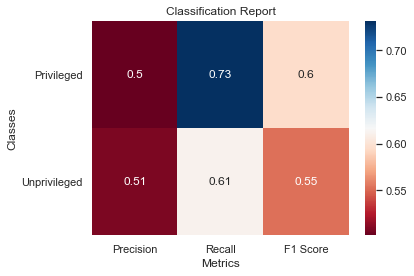

In [82]:
sampled_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    sampled2, privileged_group, unprivileged_group, debiaser=sampler, n_splits=5)

Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


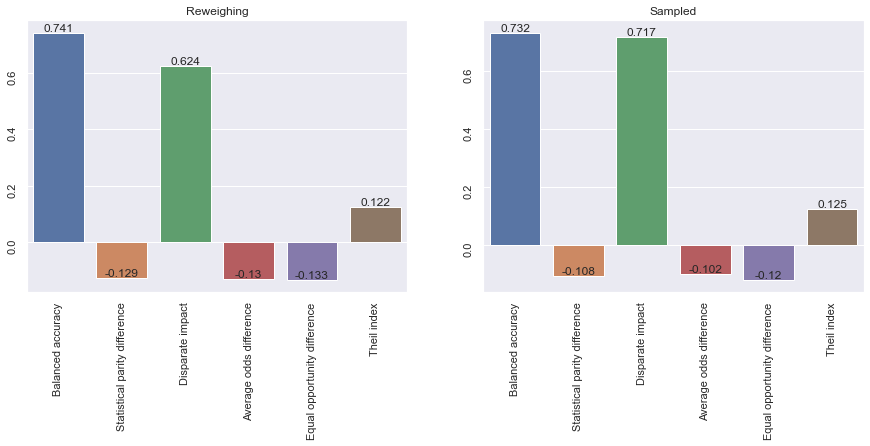

In [84]:
plot_metrics_comparison(rw_df2_class, sampled_df2_class, 'Reweighing', 'Sampled')
plt.show()

## Disparate Impact Remover

In [85]:
dir2 = df_2bin.copy()
scaler = MinMaxScaler(copy=False)
dir2.features = scaler.fit_transform(dir2.features)
df = dir2.convert_to_dataframe()[0]

In [86]:
probs = (
    df.value_counts(["sex", "race"], normalize=True).unstack().reset_index()
    .melt(id_vars='sex', value_vars=[0.0,1.0], var_name='race', value_name='probs'))

for sex,race,prob in probs.values:
    df.loc[(df['sex'] == sex) & (df['race'] == race), 'prob'] = prob

df.drop(df[['sex','race']], axis=1, inplace=True)

In [87]:
di = DisparateImpactRemover(sensitive_attribute='prob')
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])
dir2 = di.fit_transform(dir2)

In [88]:
df = dir2.convert_to_dataframe()[0]
df.loc[df['prob'].round(6) == 0.050259, 'prob'] = 0
df.loc[df['prob'].round(6) != 0, 'prob'] = 1

prob_priv_group = [{'prob': 1}]
prob_unpriv_group = [{'prob': 0}]
dir2 = BinaryLabelDataset(df = df, label_names=['income'], protected_attribute_names=['prob'])

### Dataset Metrics:

Disparate Impact: 0.2294
Statistical Parity: -0.1944




### Classification Metrics:

Balanced accuracy: 0.7291
Statistical parity difference: -0.0518
Disparate impact: 0.8570
Average odds difference: 0.0601
Equal opportunity difference: 0.0839
Theil index: 0.1238


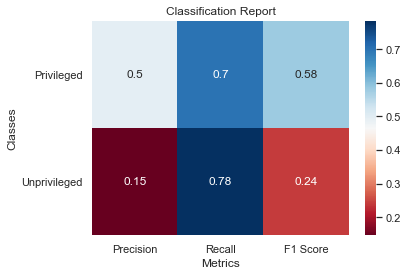

In [90]:
dir_df2_class = classify(
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'])

## Reweighing + DIR

In [91]:
dir_rw_2 = dir2.copy()
rw = Reweighing(prob_unpriv_group, prob_priv_group)

### Dataset Metrics:

Disparate Impact: 1.0000
Statistical Parity: -0.0000




### Classification Metrics:

Balanced accuracy: 0.7289
Statistical parity difference: 0.0398
Disparate impact: 1.1152
Average odds difference: 0.0369
Equal opportunity difference: 0.0309
Theil index: 0.1245


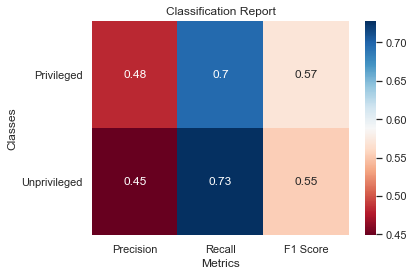

In [92]:
dir_rw_2_class = classify( 
    make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', solver='liblinear')),
    dir_rw_2, prob_priv_group, prob_unpriv_group, sensitive_attributes=['prob'], debiaser=rw)

## Algorithms comparison

metrics,Average odds difference,Balanced accuracy,Disparate impact,Equal opportunity difference,Statistical parity difference,Theil index
Dataset,,,,,,
Bias Dataset,-0.3851,0.7623,0.0890,-0.4480,-0.4522,0.1083
DIR,0.0601,0.7291,0.8570,0.0839,-0.0518,0.1238
Reweighed,-0.1302,0.7414,0.6237,-0.1333,-0.1287,0.1225
Reweighing + DIR,0.0369,0.7289,1.1152,0.0309,0.0398,0.1245
Sampled,-0.1016,0.7316,0.7169,-0.1199,-0.1080,0.1251


Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


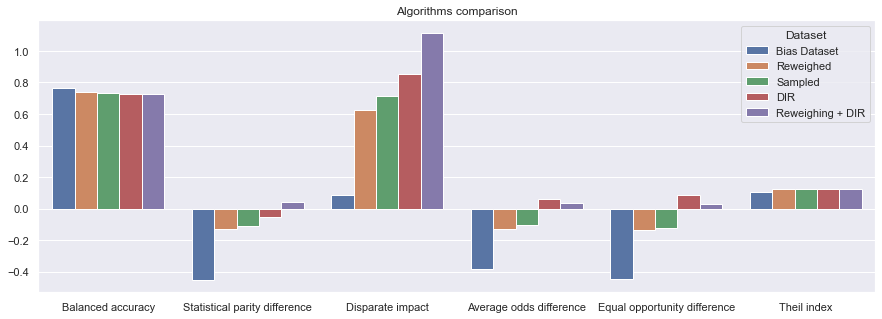

In [93]:
plot_syntesis(merge_datasets({
    'Bias Dataset': df2_class,
    'Reweighed': rw_df2_class,
    'Sampled': sampled_df2_class,
    'DIR': dir_df2_class,
    'Reweighing + DIR': dir_rw_2_class,
}), 'Algorithms comparison')
plt.show()